
# Michigan QCEW Employment (2001–2034) with Forecast Shading

This notebook plots **Michigan** QCEW employment levels (segments & stages) for **2001–2034**.
Forecast years are shaded using the `value_type == "MoodyForecast"` period from the extended files.

**Inputs (created by prior scripts):**
- `data/processed/mi_qcew_segment_employment_timeseries_extended.csv`
- `data/processed/mi_qcew_stage_employment_timeseries_extended.csv`


In [1]:

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(context="talk", style="whitegrid")
except Exception:
    pass

def find_repo_root(markers=("data", "scripts")) -> Path:
    here = Path.cwd()
    for p in (here, *here.parents):
        if all((p / m).exists() for m in markers):
            return p
    return here

REPO_ROOT = find_repo_root()
os.chdir(REPO_ROOT)
print("Working dir ->", Path.cwd())

DATA_PROCESSED = REPO_ROOT / "data" / "processed"
FIG_DIR = REPO_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

SEG_EXT = DATA_PROCESSED / "mi_qcew_segment_employment_timeseries_extended.csv"
STG_EXT = DATA_PROCESSED / "mi_qcew_stage_employment_timeseries_extended.csv"

for p in (SEG_EXT, STG_EXT):
    if not p.exists():
        raise FileNotFoundError(f"Missing required input: {p}. Run scripts/apply_moodys_growth_to_qcew.py first.")


Working dir -> c:\Users\vasilauskas\GitHub\EV-Transition


In [2]:

seg = pd.read_csv(SEG_EXT)
stg = pd.read_csv(STG_EXT)

for df in (seg, stg):
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["employment_qcew"] = pd.to_numeric(df["employment_qcew"], errors="coerce")
    df["value_type"] = df.get("value_type", "QCEW")

YR_MIN, YR_MAX = 2001, 2034
seg = seg.dropna(subset=["year"]).copy()
stg = stg.dropna(subset=["year"]).copy()
seg["year"] = seg["year"].astype(int)
stg["year"] = stg["year"].astype(int)
seg = seg[(seg["year"] >= YR_MIN) & (seg["year"] <= YR_MAX)].copy()
stg = stg[(stg["year"] >= YR_MIN) & (stg["year"] <= YR_MAX)].copy()

stage_order = ["Upstream", "OEM", "Downstream"]
if "stage" in stg.columns:
    stg["stage"] = pd.Categorical(stg["stage"], categories=stage_order, ordered=True)

print("Years (segments):", seg["year"].min(), "–", seg["year"].max())
print("Years (stages):  ", stg["year"].min(), "–", stg["year"].max())

def find_forecast_start(df):
    if "value_type" not in df.columns:
        return None
    vc = df.loc[df["value_type"].astype(str).eq("MoodyForecast"), "year"]
    return int(vc.min()) if not vc.empty else None

forecast_start_seg = find_forecast_start(seg)
forecast_start_stg = find_forecast_start(stg)
print("Forecast starts — segments:", forecast_start_seg, "stages:", forecast_start_stg)


Years (segments): 2001 – 2034
Years (stages):   2001 – 2034
Forecast starts — segments: 2025 stages: 2025


In [3]:

from matplotlib.patches import Patch

def plot_with_forecast_shading(df, group_col, y_col, title, out_png, yr_min=2001, yr_max=2034, legend_title=None, figsize=(14,8)):
    sub = df[(df["year"] >= yr_min) & (df["year"] <= yr_max)].copy()
    if sub.empty:
        print(f"[skip] No data for {title}")
        return

    fstart = int(sub.loc[sub["value_type"].astype(str).eq("MoodyForecast"), "year"].min()) if "value_type" in sub.columns and sub["value_type"].astype(str).eq("MoodyForecast").any() else None

    fig, ax = plt.subplots(figsize=figsize)
    for name, g in sub.groupby(group_col, sort=False):
        ax.plot(g["year"], g[y_col], label=str(name))

    if fstart is not None and fstart <= yr_max:
        ax.axvspan(max(fstart, yr_min), yr_max, alpha=0.12, zorder=0)
        patch = Patch(alpha=0.12, label="Forecast period (Moody’s growth)")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(patch)
        labels.append("Forecast period (Moody’s growth)")
        ax.legend(handles, labels, title=legend_title or group_col.replace("_"," ").title(), bbox_to_anchor=(1.02,1), loc="upper left")
    else:
        ax.legend(title=legend_title or group_col.replace("_"," ").title(), bbox_to_anchor=(1.02,1), loc="upper left")

    ax.set_xlim(yr_min, yr_max)
    ax.set_xlabel("Year")
    ax.set_ylabel("Employment (QCEW)")
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved: {out_png}")
    plt.show()
    plt.close(fig)


## Segments — Michigan QCEW Employment (2001–2034)

Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_segments_2001_2034_with_forecast.png


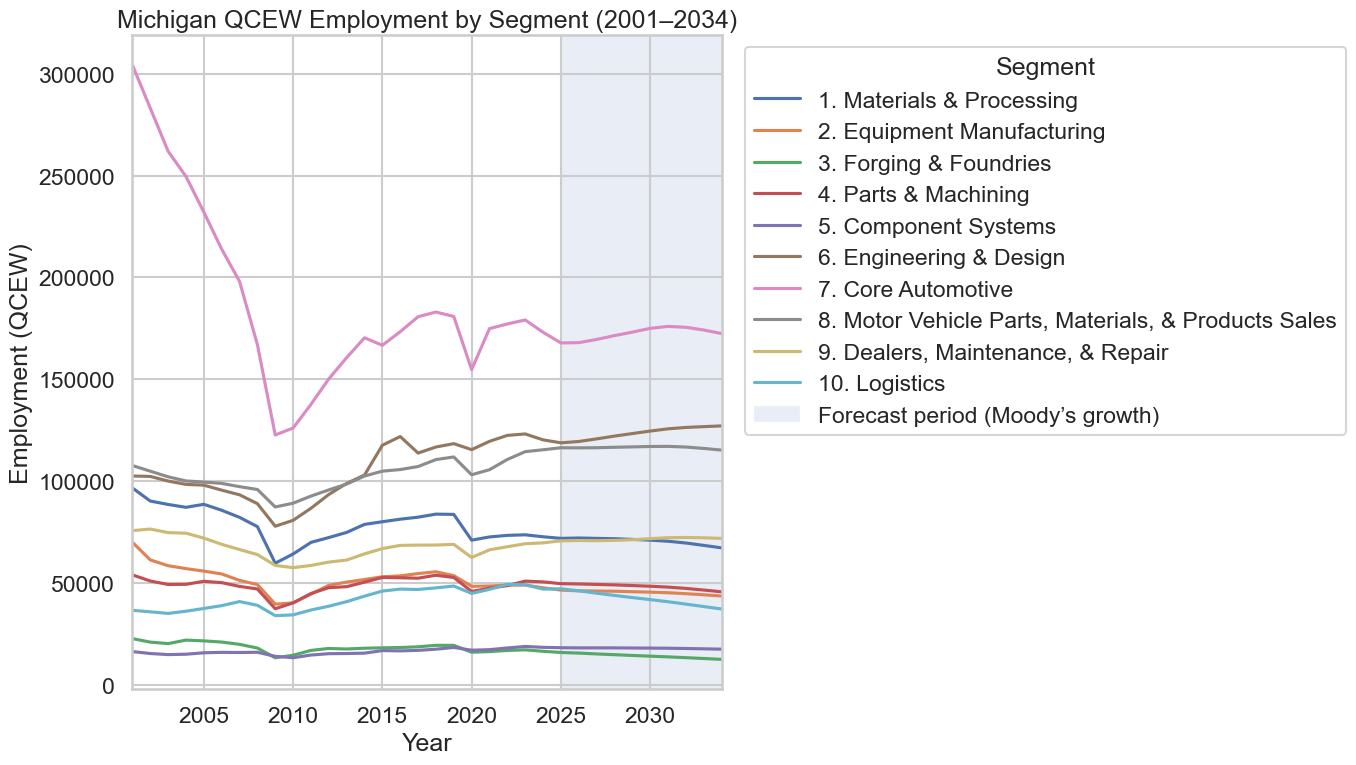

In [4]:

plot_with_forecast_shading(
    df=seg,
    group_col="segment_label" if "segment_label" in seg.columns else "segment_name",
    y_col="employment_qcew",
    title="Michigan QCEW Employment by Segment (2001–2034)",
    out_png=FIG_DIR / "mi_qcew_segments_2001_2034_with_forecast.png",
    yr_min=YR_MIN, yr_max=YR_MAX,
    legend_title="Segment"
)


## Stages — Michigan QCEW Employment (2001–2034)

C:\Users\vasilauskas\AppData\Local\Temp\ipykernel_45824\1463796734.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in sub.groupby(group_col, sort=False):


Saved: c:\Users\vasilauskas\GitHub\EV-Transition\reports\figures\mi_qcew_stages_2001_2034_with_forecast.png


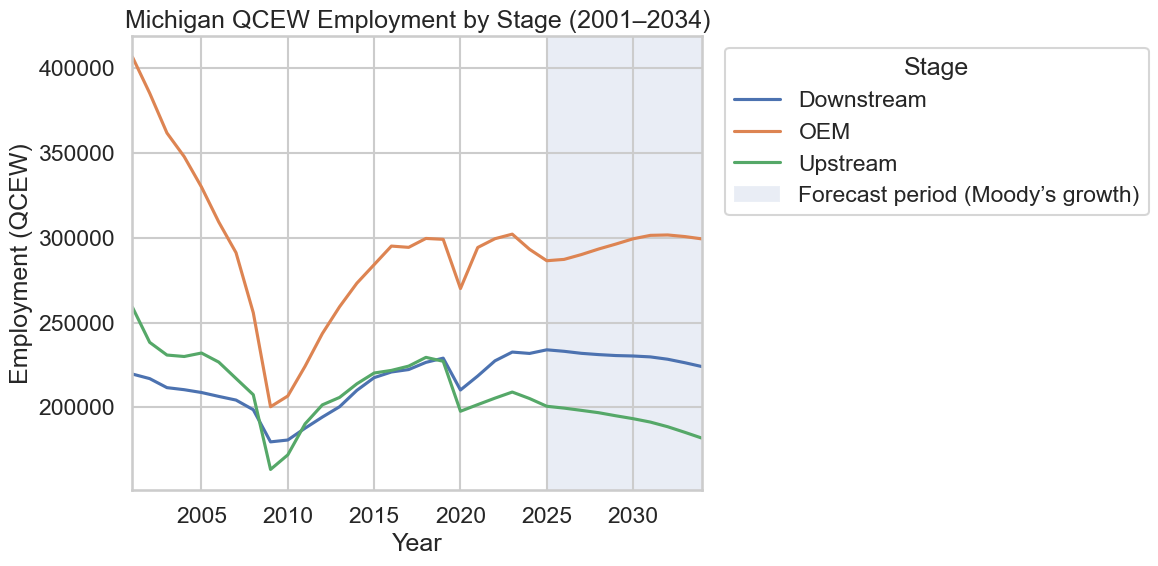

In [5]:

plot_with_forecast_shading(
    df=stg,
    group_col="stage",
    y_col="employment_qcew",
    title="Michigan QCEW Employment by Stage (2001–2034)",
    out_png=FIG_DIR / "mi_qcew_stages_2001_2034_with_forecast.png",
    yr_min=YR_MIN, yr_max=YR_MAX,
    legend_title="Stage",
    figsize=(12,6)
)
